# Instructions

Create a NN network with 5 layers. Train and test the model. (2p) 

- Choose a dataset (CSV or any other image dataset).
- Utilize the dataloader.
- Design the NN model.
- Train and test the model.

In [ ]:
import pandas as pd
from pyprojroot import here
from pathlib import Path

# Download dataset if not already present
if not (here(r"data/sign_language_mnist/sign_mnist_train.csv").exists()):
  import kagglehub
  dwnl_path: str = kagglehub.dataset_download(
    "datamunge/sign-language-mnist",
  )
  # move the downloaded files to the correct location
  import shutil
  dest_dir = here(r"data/sign_language_mnist")
  dest_dir.mkdir(parents=True, exist_ok=True)
  shutil.move(
    Path(dwnl_path) / "sign_mnist_train.csv",
    dest_dir / "sign_mnist_train.csv"
  )
  shutil.move(
    Path(dwnl_path) / "sign_mnist_test.csv",
    dest_dir / "sign_mnist_test.csv"
  )
pd.read_csv(here(r"data/sign_language_mnist/sign_mnist_train.csv"))

100%|██████████| 62.6M/62.6M [00:05<00:00, 12.4MB/s]

Extracting files...


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27450,13,189,189,190,190,192,193,193,193,193,...,132,165,99,77,52,200,234,200,222,225
27451,23,151,154,157,158,160,161,163,164,166,...,198,198,198,198,198,196,195,195,195,194
27452,18,174,174,174,174,174,175,175,174,173,...,121,196,209,208,206,204,203,202,200,200
27453,17,177,181,184,185,187,189,190,191,191,...,119,56,27,58,102,79,47,64,87,93


In [ ]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
from pathlib import Path


class SignMNIST(Dataset):
  def __init__(self, path: Path):
    self.df = pd.read_csv(path)
    self.target: np.array = self.df["label"].values
    self.data = self.df.drop(columns=["label"]).values
    self.data = self.data.reshape(self.data.shape[0], 28, 28)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index: list[int]) -> tuple:
    image = self.data[index]  # shape (28, 28)

    image = image.astype(np.float32) / 255.0  # min max Normalize to [0, 1]
    image = np.expand_dims(image, axis=0)  # Add channel dimension (C x H x W)

    label = self.target[index]
    label = torch.tensor(label, dtype=torch.int64)

    return image, label

  @staticmethod
  def label_to_letter(label: int) -> str:
    return chr(label + 65)

  @property
  def shape(self) -> tuple:
    return self.data.shape, self.target.shape


np.random.seed(1)
torch.manual_seed(1)
train_dataloader = DataLoader(
  train := SignMNIST(here(r"data/sign_language_mnist/sign_mnist_train.csv")),
  batch_size=64,
  shuffle=True,
)
test_dataloader = DataLoader(
  test := SignMNIST(here(r"data/sign_language_mnist/sign_mnist_test.csv")),
  batch_size=64,
  shuffle=True,
)
train_dataloader

In [3]:
train.shape, test.shape

(((27455, 28, 28), (27455,)), ((7172, 28, 28), (7172,)))

In [4]:
train[0][0].shape, train[0][1]  # (C, H, W), label

((1, 28, 28), tensor(3))

24


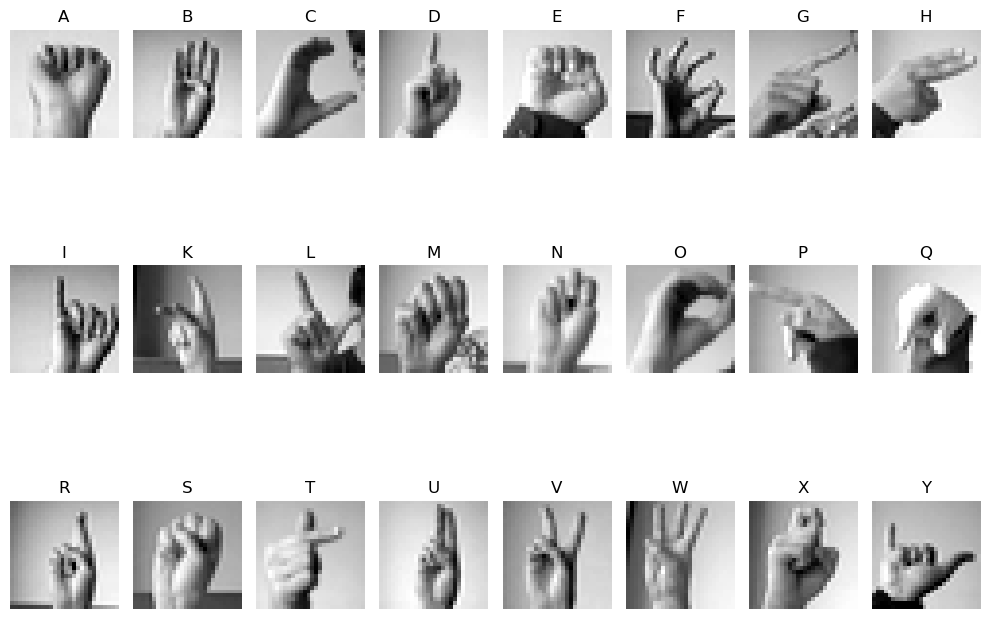

In [5]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(10, 10))
rows, columns = 4, 8
list_of_letters = set(train.target) | set(
  test.target
)  # Extract unique labels from the dataset
print(len(list_of_letters))

for i, letter in enumerate(sorted(list_of_letters)):
  ax = figure.add_subplot(rows, columns, i + 1)
  ax.set_title(SignMNIST.label_to_letter(letter))  # Convert label to letter
  ax.axis("off")
  # Display the first image corresponding to the current letter
  ax.imshow(train.data[train.target == letter][0], cmap="gray")

figure.tight_layout()
plt.show()

In [6]:
import torch.nn as nn


class NN(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.relu_stack = nn.Sequential(
      nn.Linear(28 * 28, 2**9),
      nn.ReLU(),
      nn.Linear(2**9, 2**8),
      nn.ReLU(),
      nn.Linear(2**8, 2**7),
      nn.ReLU(),
      nn.Linear(2**7, 2**6),
      nn.ReLU(),
      nn.Linear(
        2**6, 26
      ),  # 24 letters in the dataset, but 26 letters in the alphabet (to not go out of bounds)
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.flatten(x)
    logits = self.relu_stack(x)
    return logits


model = NN().to(
  device := torch.accelerator.current_accelerator().type
  if torch.accelerator.is_available()
  else "cpu"
)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device, criterion, optimizer, model

('cpu',
 CrossEntropyLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0
 ),
 NN(
   (flatten): Flatten(start_dim=1, end_dim=-1)
   (relu_stack): Sequential(
     (0): Linear(in_features=784, out_features=512, bias=True)
     (1): ReLU()
     (2): Linear(in_features=512, out_features=256, bias=True)
     (3): ReLU()
     (4): Linear(in_features=256, out_features=128, bias=True)
     (5): ReLU()
     (6): Linear(in_features=128, out_features=64, bias=True)
     (7): ReLU()
     (8): Linear(in_features=64, out_features=26, bias=True)
   )
 ))

In [ ]:
def train_model(model, dataloader, epochs=5):
  model.train()
  for epoch in range(epochs):
    total_loss = 0
    for images, labels in dataloader:
      images, labels = images.to(device), labels.to(device)

      outputs = model(images)
      loss = criterion(outputs, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      total_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(dataloader):.4f}")


def test_model(model, dataloader):
  model.eval()
  correct, total = 0, 0

  with torch.no_grad():
    for images, labels in dataloader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  print(f"Accuracy: {100 * correct / total:.2f}%")


np.random.seed(1)
torch.manual_seed(1)
model = model.to(device)
train_model(model, train_dataloader, epochs=10)
test_model(model, test_dataloader)

Epoch 1, Loss: 2.5339
Epoch 2, Loss: 1.7193
Epoch 3, Loss: 1.3495
Epoch 4, Loss: 1.0637
Epoch 5, Loss: 0.7874
Epoch 6, Loss: 0.5891
Epoch 7, Loss: 0.4575
Epoch 8, Loss: 0.3272
Epoch 9, Loss: 0.2763
Epoch 10, Loss: 0.1629
Accuracy: 69.49%


Correct Predictions:


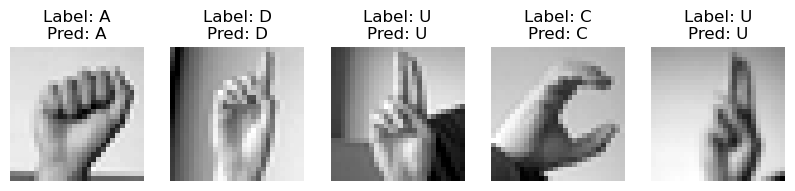

Incorrect Predictions:


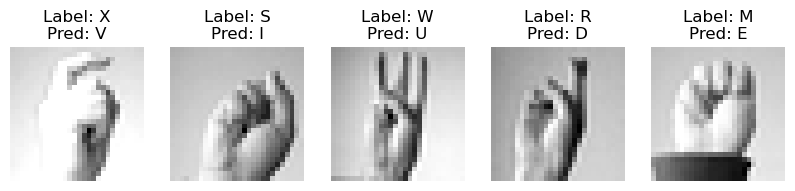

In [ ]:
# Generated
def show_examples(model, dataloader, num_examples=5):
  model.eval()
  correct_examples, incorrect_examples = [], []

  with torch.no_grad():
    for images, labels in dataloader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs, 1)

      for i in range(len(labels)):
        if len(correct_examples) < num_examples and predicted[i] == labels[i]:
          correct_examples.append(
            (images[i].cpu(), labels[i].cpu(), predicted[i].cpu())
          )
        elif len(incorrect_examples) < num_examples and predicted[i] != labels[i]:
          incorrect_examples.append(
            (images[i].cpu(), labels[i].cpu(), predicted[i].cpu())
          )

        if (
          len(correct_examples) >= num_examples
          and len(incorrect_examples) >= num_examples
        ):
          break

  # Plot correct examples
  print("Correct Predictions:")
  figure = plt.figure(figsize=(10, 5))
  for i, (image, label, pred) in enumerate(correct_examples):
    ax = figure.add_subplot(1, num_examples, i + 1)
    ax.set_title(
      f"Label: {SignMNIST.label_to_letter(label)}\nPred: {SignMNIST.label_to_letter(pred)}"
    )
    ax.axis("off")
    ax.imshow(image.squeeze(), cmap="gray")
  plt.show()

  # Plot incorrect examples
  print("Incorrect Predictions:")
  figure = plt.figure(figsize=(10, 5))
  for i, (image, label, pred) in enumerate(incorrect_examples):
    ax = figure.add_subplot(1, num_examples, i + 1)
    ax.set_title(
      f"Label: {SignMNIST.label_to_letter(label)}\nPred: {SignMNIST.label_to_letter(pred)}"
    )
    ax.axis("off")
    ax.imshow(image.squeeze(), cmap="gray")
  plt.show()


np.random.seed(1)
torch.manual_seed(1)
show_examples(model, test_dataloader)